<a href="https://colab.research.google.com/github/vinaikchhetri/Tetris/blob/master/finale2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
np.set_printoptions(precision = 4, suppress = True)
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets
from copy import copy
import random
import scipy.stats


In [61]:
twoDWorldb = []
twoDWorldw = []
c = [['black','black','black','black','black','black','black','white','white','white'],['black','black','black','black','black','black','black','white','white','white']
     ,['black','black','black','black','black','black','black','white','white','white'],['black','black','black','black','black','black','black','black','black','black']];
mapTile = np.array(c)
y = 4

for i in range(4):
  x = -2;
  y = y - 2
  for j in range(10):
    x = x + 2
    if c[i][j] == 'black':
      twoDWorldb.append(matplotlib.patches.Rectangle((x, y),
                                      2, 2,
                                      alpha = 0.5,
                                      color = c[i][j]))
    else:
      twoDWorldw.append(matplotlib.patches.Rectangle((x,y),
                                      2, 2,
                                      alpha = 0.1,
                                      color = c[i][j]))
mapTile = mapTile=='black'
mapTile = (mapTile).astype(int)

In [62]:
def mktr(x, y):
    return np.array([[1,0,x],
                     [0,1,y],
                     [0,0,1]])

def mkrot(theta):
    return np.array([[np.cos(theta),-np.sin(theta),0],
                     [np.sin(theta), np.cos(theta),0],
                     [0,0,1]])

def drawf(f, ax = None, name = None):
    """ Draw frame defined by f on axis ax (if provided) or on plt.gca() otherwise """
    xhat = f @ np.array([[0,0,1],[1,0,1]]).T
    yhat = f @ np.array([[0,0,1],[0,1,1]]).T
    if(not ax):
        ax = plt.gca()
    ax.plot(xhat[0,:],xhat[1,:],'r-') # transformed x unit vector
    ax.plot(yhat[0,:],yhat[1,:],'g-') # transformed y unit vector
    if(name):
        ax.text(xhat[0,0],xhat[1,0],name,va="top",ha="center")

In [63]:
def bctr(v,gamma,L,dt):
    """ returns the pose transform for a motion with duration dt of a steerable
    robot (bicycle model) with back wheel speed v, steering gamma and wheel distance L """
    
    if(np.isclose(gamma,0)): # we are moving straight, R is at the infinity and we handle this case separately
        return mktr(v*dt,0)  # note we translate along x
    
    R = L / np.tan(gamma) # Make sure you understand this!
    omega = v / R         # Make sure you understand this!
    
    return mktr(0,R) @ mkrot(omega * dt) @ mktr(0,-R) 

In [64]:
def drawrobot_bicycle(f, particles, gamma, L, ax = None, alpha = 0.5,patch="yes"):
    """ Draw bicycle robot at pose f, with wheel distance L,
    on axis ax (if provided) or on plt.gca() otherwise. """
    
    if(not ax):
        ax = plt.gca()
    
    # This is the chassis of the robot, a thin arrow
    robot = ([[ 0  , 1  , 1  , 0  , 0  ],  # x
              [-0.3,-0.1, 0.1, 0.3,-0.3]]) # y 
    robot = np.array(robot)
    robot = np.vstack((
        robot * L, # scale by L units: back is center of the back wheel; tip is the center of the front wheel
        np.ones((1,robot.shape[1]))))
    # ... and now it's in homogeneous coordinates

    # define back and front wheels
    wheelb = np.array([
        [-L*0.3, +L*0.3], # wheel diameter does not matter. It's now 0.6*L
        [ 0,      0    ],
        [ 1,      1    ]
    ])    
    wheelf = mktr(L,0) @ mkrot(gamma) @ wheelb # make sure you understand this!
    
    # transform robot and both wheels
    robott = f @ robot
    wheelbt = f @ wheelb
    wheelft = f @ wheelf

    if patch=="yes":
      for i in range(len(twoDWorldb)):
        ax.add_patch(copy(twoDWorldb[i]))

      for i in range(len(twoDWorldw)):
        ax.add_patch(copy(twoDWorldw[i]))

    plt.xlim([0, 20])
    plt.ylim([-4, 4])
    
    ax.plot(robott[0,:],robott[1,:],'k-',alpha=alpha)   # Draw the chassis
    ax.plot(wheelbt[0,:],wheelbt[1,:],'k-',alpha=alpha, linewidth = 2) # Draw the back wheel
    ax.plot(wheelft[0,:],wheelft[1,:],'k-',alpha=alpha, linewidth = 2) # Draw the front wheel
    
    desired_xy = np.array([2, 2])
    ax.plot(*desired_xy, "*",c="red")
    plot_particles(ax,particles)

In [65]:
from numpy.random import uniform
def create_uniform_particles(N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(0, 20, size=N) #random x
    particles[:, 1] = uniform(-4, 4, size=N) #random y
    particles[:, 2] = uniform(-np.pi, np.pi, size=N) #random theta
    return particles

In [66]:
class BCRobot:
    def __init__(self, initial_pose, L):
        self.pose = initial_pose # will always store the current pose
        self.L = L
        p = np.array([[1/1000] for i in range(1000)])
        I = create_uniform_particles(1000)
        I = np.concatenate((I, p), axis=1)
        self.r = I
        
    def step(self, v, gamma, dt):
        self.pose = self.pose @ bctr(v, gamma, self.L, dt) # this is where the magic happens
        return self.pose
    
    def getxy(self):
        return self.pose[0:2,2] # extracts [x,y] from current pose
    
    def gettheta(self): # sin(theta)      cos(theta)
        return np.arctan2(self.pose[1,0], self.pose[0,0])

In [67]:
def motion_update(X,v,gamma):
  #print("X[3]",X[3,0:2])
  for i in range(len(X)):
    X[i,2] = X[i,2] + gamma
    f = bctr(v, X[i,2], L, 0.1)
    cord = (X[i,0:2])
    m = np.eye(3)
    m[0,2] = cord[0]  
    m[1,2] = cord[1]
    #cord = np.append(cord,1).reshape(3,1)
    #np.append(cord,[[1]],axis=0)
    #print("cord",cord)
    transformed = m@f
    #print("trans",transformed)
    X[i,0:2] = transformed[0:2,2]
  #print("X[3]2nd",X[3,0:2])
  X = X[X[:,0] <= 20]
  X = X[X[:,0] >= 0]
  X = X[X[:,1] <= 4]
  X = X[X[:,1] >= -4]
  return X


In [68]:
def sensor_update(X, sensor_reading, map_Tile):

  #Convert float/double particle locations to integers
  locx = np.floor(X[:,0]).astype(int)
  locy = np.floor(X[:,1]).astype(int)
  
  for i in range(len(locx)):
    
    if locx[i] >= 20:
      locx[i] = 9
    elif locx[i]%2 == 0:
      locx[i] = locx[i]/2
    else:
      locx[i] = locx[i]//2

  for i in range(len(locy)):
    
    if locy[i] >= 2 and locy[i] <= 4:
      locy[i] = 0
    elif locy[i] >= 0 and locy[i] <= 1:
      locy[i] = 1
    elif locy[i]>=-2 and locy[i] <= -1: 
      locy[i] = 2
    else:
      locy[i] = 3
  
 
  #given locations of particles find colour of tile in map according to coordinates/odometry
  #predict_sensor = map_Tile[loc.astype(int)]
  predict_sensor = np.zeros(len(X))
  # predict_sensor = []
  # print("length of X",len(X))
  # print("length of X",X.shape)
  for i in range(len(X)):
    predict_sensor[i]=(map_Tile[locy[i]][int(locx[i])])

  #print("predict sensor",predict_sensor)
  #print("sensor reading",sensor_reading)
  #print("equality indices",X[predict_sensor==sensor_reading])
  # #Probability of actual sensor reading given predicted sensor readings corresponding to each predicted sensor reading. 1 probability distribution per particle.
  distribution = scipy.stats.norm(predict_sensor,0.1).pdf(sensor_reading)
  #print("Liklihood of actual sensor reading given current coordinates of particles",distribution)
  # #update weights
  X[:,3] = X[:,3] * distribution
  #print("new weights",X[:,3])
  # #normalize 
  X[:,3] = X[:,3] / sum(X[:,3])
  #print("normalized new weights",X[:,3])
  return X



In [69]:
def detect_color(actual_location, map_Tile):
  #Convert float/double particle locations to integers
  locx = np.floor(actual_location[0])
  locy = np.floor(actual_location[1])


  if locx >= 20:
    locx = np.floor(9.0)
  elif locx%2 == 0:
    locx = locx/2
  else:
    locx = locx//2
  
  locx = int(locx)


  if locy >= 2 and locy <= 4:
    locy = 0
  elif locy >= 0 and locy < 2:
    locy = 1
  elif locy>=-2 and locy < 0: 
    locy = 2
  elif locy>=-4 and locy < -2: 
    locy = 3
  else :
    donothing =0

  n = random.randint(1,10)

  if n==1:
    print("error")
    return (map_Tile[locy][locx] + 1)%2
  else:
    return (map_Tile[locy][locx])

In [70]:
def MCL (X_m_1, actual_location, map_Tile,v, gamma):
  
  #motion update
  X_bar = np.array(motion_update(X_m_1,v,gamma))

  if X_bar.size == 0:
    return X_bar
  

  #sense
  z_t = detect_color(actual_location, map_Tile)

  #sensor update
  X_bar = sensor_update(X_bar, z_t, map_Tile)
  pos_pro = []
  for i in range(len(X_bar)):
    if X_bar[i,3]>0:
      pos_pro.append(X_bar[i])
  X_bar = np.array(pos_pro)


  #resample based on new weights
  #if len(X_bar) >= 100:
  #  num_part = len(X_bar/10)
  #else: 
  #num_part = len(X_bar)
  num_part = 500
  #extract weights
  temp = X_bar
  newX = np.zeros([num_part,4])
  #print(temp[:,3])
  for i in range(num_part):
    loca = np.random.choice(temp.shape[0],p=temp[:,3])
    newX[i,:] = temp[loca]
    newX[i,0] = scipy.stats.norm.rvs(size=1)+newX[i,0]
    newX[i,1] = scipy.stats.norm.rvs(size=1)+newX[i,1]

  #print("newly sampled X",newX)
  
  #X_bar = X_bar[np.argsort(X_bar[:, 3])]
  #cdf = np.cumsum(X_bar[:,3])
  #cdf[-1] = 1
  # print("X_bar",X_bar)
  # print("cdf",cdf)
  #X_bar[:,0:3] = random.choices(X_bar[:,0:3], cum_weights = cdf, k = len(X_bar))
  # print("picked",X_bar)
  
  #25% of the time replace with random numbers as particles gather at wrong places.
  num=range(1,25)
  
  #generate random integers from 1 to 100
  rep = random.randint(1,101)
  #print("num_rep",rep)
  if rep<=25 and rep>=1:
    num_reps = int(np.floor(0.05*len(newX)))
    for n in  range(num_reps):
 
      #ind = random.randint(0,len(newX)-1)
      rep_particles = np.empty((1, 4))
      rep_particles[:, 0] = uniform(0, 20, size=1) #random x
      rep_particles[:, 1] = uniform(-4, 4, size=1) #random y
      rep_particles[:, 2] = uniform(-np.pi, np.pi, size=1) #random theta
      rep_particles[:, 3] = 0.2 #weight arbitrary
      newX = np.concatenate((newX,rep_particles), axis=0)
  #     # newX[ind,:] = rep_particles
      
  for i in range(len(newX[:,0])):
    newX[i,3] = 1/len(newX[:,0])

  X = newX 
  # for i in range(len(X_bar[:,0])):
  #   X_bar[i,3] = 1/len(X_bar[:,0])

  # X = X_bar
  


  return X  

In [71]:
def plot_particles(ax,X):
    ax.scatter(X[:,0],X[:,1],c='blue') 
    plt.pause(0.5)

In [72]:
# This is a classic implementation: https://stackoverflow.com/a/2007279
def angle_difference(angle1, angle2):
    return np.arctan2(np.sin(angle1-angle2), np.cos(angle1-angle2))

In [73]:
# Then a PID controller
class PID:
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki # NEW
        self.Kd = Kd
        self.last_e = None
        self.sum_e = 0 # NEW
        
    def step(self, e, dt):
        """ dt should be the time interval from the last method call """
        if(self.last_e is not None):
            derivative = (e - self.last_e) / dt
        else:
            derivative = 0
        self.last_e = e
        self.sum_e += e * dt # NEW
        return self.Kp * e + self.Kd * derivative + self.Ki * self.sum_e

In [74]:
from IPython.display import clear_output
    

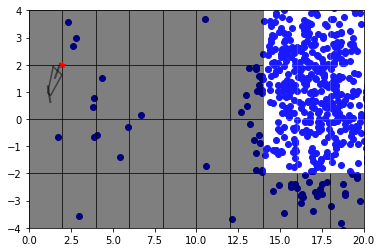

In [75]:
initial_pose = np.eye(3) @ mktr(2, 2) 
L = 1
robot = BCRobot(initial_pose, L)
maxsteer = np.pi/4  # we will limit our steering to this range
maxspeed = 5
desired_xy = np.array([18,3])
#desired_xy = np.array([20, 0])

speed_controller = PID(5, 0.2, 0.1)
gamma_controller = PID(2, 0.2, 0.1)

dt = 0.1
ts = np.arange(0, 3, dt)


for t in ts:  # we simulate 10 seconds
    plt.pause(1)
    clear_output(wait=True)
    
    x, y = robot.getxy()
    theta = robot.gettheta()

    # position of target in robot frame
    target_rf = np.linalg.inv(robot.pose) @ np.array(
        [[desired_xy[0], desired_xy[1], 1]]).T
    angle_to_target = np.arctan2(target_rf[1, 0], target_rf[0, 0])
    distance_to_target = target_rf[0, 0]

    v = speed_controller.step(distance_to_target, dt)
    v = np.clip(v, -maxspeed, +maxspeed)
    gamma = gamma_controller.step(angle_to_target, dt)
    gamma = np.clip(gamma, -maxsteer, +maxsteer)

    #velocity measurement error
    #25% of the time replace with random numbers as particles gather at wrong places.
    num=range(1,16)
    
    #generate random integers from 1 to 100
    rep = random.randint(1,101)
    #print("num_rep",rep)
    if rep<=15 and rep>=1:
      v = v + (0.1*v)
      gamma = gamma + (0.01*gamma)
    

    robot.step(v, gamma, dt)
    r = MCL(robot.r, robot.pose[0:2,2], mapTile, v, gamma)
    if r.size == 0:
      p = np.array([[1/1000] for i in range(1000)])
      I = create_uniform_particles(1000)
      I = np.concatenate((I, p), axis=1)
    
      robot.r = I
    else:
      robot.r = r
    #print(rrr.pose)
    #print(robot.r)
    drawrobot_bicycle(robot.pose, robot.r,gamma, L)
    #print(robot.r[:,2])

x = robot.r[:,0]
nx, binsx, patchesx = plt.hist(x, bins=20)
xmode_index = nx.argmax()
xs = binsx[xmode_index]
#ind = np.argwhere(x==binsx[xmode_index])[0][0]
#thet = robot.r[ind,2]

y = robot.r[:,1]
ny, binsy, patchesy = plt.hist(y, bins=8)
ymode_index = ny.argmax()
ys = binsy[ymode_index]

thet = robot.r[:,2]
nt, binst, patchest = plt.hist(thet, bins=12)
tmode_index = nt.argmax()
ts = binst[tmode_index]


#####
desired_xy = np.array([2, 2])
x = xs
y = ys
theta = ts
pose = np.eye(3) @ mktr(x, y) @ mkrot(theta)
distance_to_target = 10
while distance_to_target >=0.2:
  
  plt.pause(1)
  clear_output(wait=True)
  # position of target in robot frame
  target_rf = np.linalg.inv(pose) @ np.array(
      [[desired_xy[0], desired_xy[1], 1]]).T
  angle_to_target = np.arctan2(target_rf[1, 0], target_rf[0, 0])
  distance_to_target = np.sqrt(np.square(target_rf[0, 0])+np.square(target_rf[1, 0]))

  v = speed_controller.step(distance_to_target, dt)
  v = np.clip(v, -maxspeed, +maxspeed)
  gamma = gamma_controller.step(angle_to_target, dt)
  gamma = np.clip(gamma, -maxsteer, +maxsteer)
  robot.step(v, gamma, dt)
  pose = robot.pose
  drawrobot_bicycle(robot.pose, robot.r,gamma, L)